In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df= pl.read_parquet('2014_data.parquet')

In [ ]:
wanted_subcategories = [
    "Headphones, Earbuds & Accessories",
    "Television & Video",
    "Car & Vehicle Electronics",
    "Portable Audio & Video"
]
filtered_df = df.filter(pl.col("sub_category").is_in(wanted_subcategories))

In [ ]:
filtered_df.write_parquet("final.parquet")

Weighted Smoothing

In [ ]:
def generate_monthly_avg_of_weekly_sentiment(
    parquet_path: str,
    smoothing_window: int = 3,
):
    df = pl.read_parquet(parquet_path)
    schema = df.schema

    df = df.with_columns([
        pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%.f", strict=False).alias("review_date")
        if schema["timestamp"] == pl.Utf8 else pl.col("timestamp").alias("review_date"),
        pl.col("Date First Available").str.to_date("%Y-%m-%d", strict=False).alias("product_first_available")
        if schema["Date First Available"] == pl.Utf8 else pl.col("Date First Available").alias("product_first_available")
    ]).drop_nulls(["review_date", "product_first_available"])

    df = df.with_columns(
        (pl.col("review_date") - pl.col("product_first_available")).dt.total_days().alias("days_since_launch")
    ).filter(pl.col("days_since_launch") >= 0)

    df = df.with_columns([
        (pl.col("days_since_launch") // 7).cast(pl.Int32).alias("week_bin"),
        (pl.col("days_since_launch") // 30).cast(pl.Int32).alias("month_bin")
    ])

    weekly_df = df.group_by(["sub_category", "month_bin", "week_bin"]).agg([
        pl.mean("bert_score").alias("weekly_avg_sentiment"),
        pl.count("bert_score").alias("weekly_review_count")
    ])

    monthly_df = weekly_df.group_by(["sub_category", "month_bin"]).agg([
        (pl.col("weekly_avg_sentiment") * pl.col("weekly_review_count")).sum().alias("weighted_sent_sum"),
        pl.col("weekly_review_count").sum().alias("monthly_review_count")
    ])

    monthly_df = monthly_df.with_columns(
        (pl.col("weighted_sent_sum") / pl.col("monthly_review_count")).alias("monthly_avg_sentiment")
    ).sort(["sub_category", "month_bin"])

    result = {}
    for sub_cat in monthly_df["sub_category"].unique().to_list():
        cat_df = monthly_df.filter(pl.col("sub_category") == sub_cat).to_pandas()

        if cat_df.empty:
            continue

        min_bin, max_bin = int(cat_df["month_bin"].min()), int(cat_df["month_bin"].max())
        full_index = pd.DataFrame({"month_bin": range(min_bin, max_bin + 1)})

        merged = full_index.merge(cat_df, on="month_bin", how="left").fillna({
            "monthly_avg_sentiment": 0,
            "monthly_review_count": 0
        })

        merged["weighted_sentiment"] = merged["monthly_avg_sentiment"] * merged["monthly_review_count"]
        merged["smoothed_sentiment"] = (
            merged["weighted_sentiment"].rolling(smoothing_window, min_periods=1).sum() /
            merged["monthly_review_count"].rolling(smoothing_window, min_periods=1).sum()
        )
        merged["sub_category"] = sub_cat
        result[sub_cat] = merged

    return result


def plot_monthly_sentiment(result_dict):
    for sub_cat, df in result_dict.items():
        if df["monthly_review_count"].sum() == 0:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(df["month_bin"], df["smoothed_sentiment"], label="Smoothed Monthly Sentiment")
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.ylim(-1, 1)
        plt.xticks(range(0, df["month_bin"].max() + 1, 6))  # 6-month interval ticks
        plt.title(f"Smoothed Sentiment (Avg of Weekly) per Month – {sub_cat}")
        plt.xlabel("Months Since Launch")
        plt.ylabel("Sentiment [-1, 1]")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()

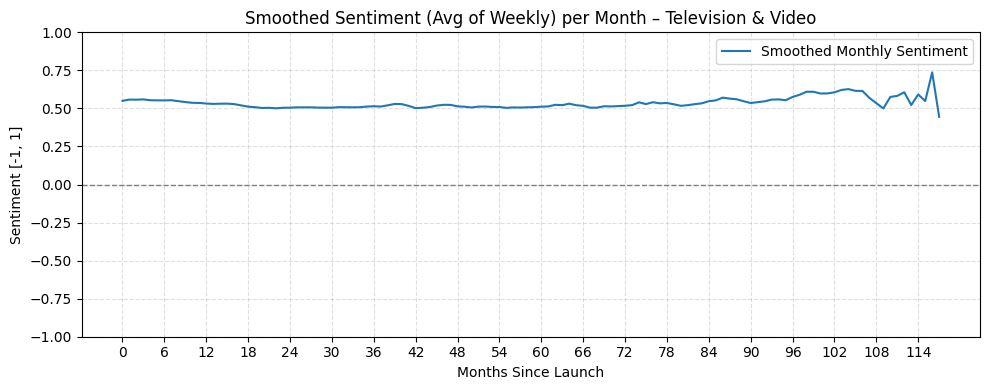

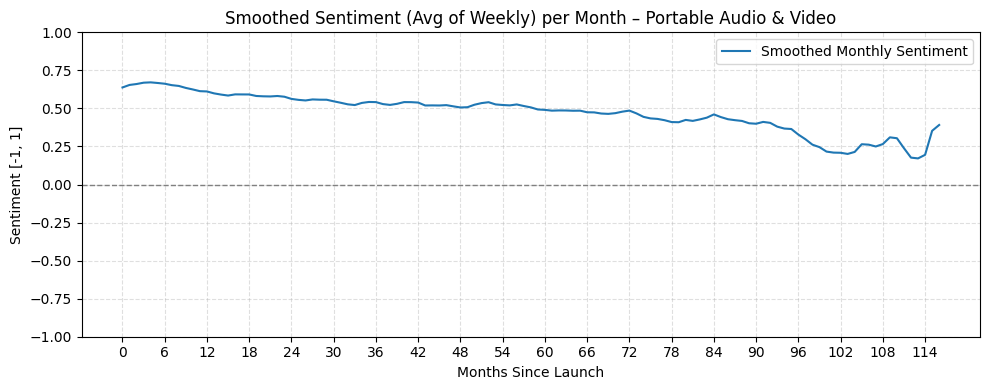

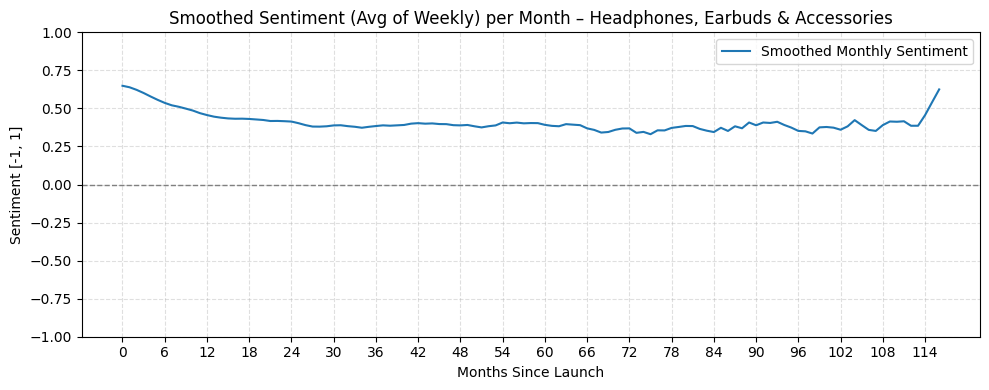

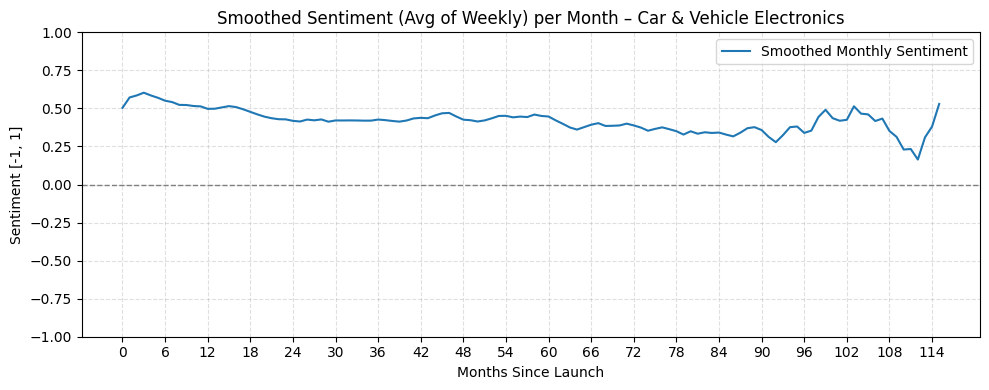

In [ ]:
result = generate_monthly_avg_of_weekly_sentiment("final.parquet", smoothing_window=3)
plot_monthly_sentiment(result)

LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, dropout=0.0, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

def tune_lstm_hyperparameters(
    result_dict,
    param_grid,
    epochs=100,
    verbose=True
):
    results = []
    combinations = list(itertools.product(
        param_grid["sequence_length"],
        param_grid["hidden_size"],
        param_grid["dropout"],
        param_grid["weight_decay"],
        param_grid["patience"],
        param_grid["num_layers"]
    ))

    for sub_cat, df in result_dict.items():
        y = df["smoothed_sentiment"].dropna().values
        if len(y) < 20:
            continue

        for seq_len, hidden, drop, decay, pat, layers in combinations:
            if drop > 0 and layers == 1:
                continue 

            scaler = MinMaxScaler()
            y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

            split_idx = int(len(y_scaled) * 0.7)
            train_seq, test_seq = y_scaled[:split_idx], y_scaled[split_idx:]
            X_train, y_train = create_sequences(train_seq, seq_len)
            X_test, y_test = create_sequences(test_seq, seq_len)

            if len(X_test) < 5 or len(X_train) < 5:
                continue

            X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
            y_train_tensor = torch.FloatTensor(y_train)
            X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
            y_test_tensor = torch.FloatTensor(y_test)

            model = LSTMModel(hidden_size=hidden, num_layers=layers, dropout=drop)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=decay)

            train_losses, val_losses = [], []
            best_val_loss = float("inf")
            best_model = None
            epochs_no_improve = 0

            for epoch in range(epochs):
                model.train()
                output = model(X_train_tensor).squeeze()
                loss = criterion(output, y_train_tensor)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.eval()
                with torch.no_grad():
                    val_pred = model(X_test_tensor).squeeze()
                    val_loss = criterion(val_pred, y_test_tensor)

                train_losses.append(loss.item())
                val_losses.append(val_loss.item())

                if val_loss.item() < best_val_loss:
                    best_val_loss = val_loss.item()
                    best_model = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= pat:
                        break

            model.load_state_dict(best_model)
            model.eval()
            with torch.no_grad():
                preds = model(X_test_tensor).squeeze().numpy()
                y_true = y_test_tensor.numpy()

            preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
            y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(y_true_inv, preds_inv)
            mse = mean_squared_error(y_true_inv, preds_inv)

            results.append({
                "Subcategory": sub_cat,
                "Sequence Length": seq_len,
                "Hidden Size": hidden,
                "Dropout": drop,
                "Weight Decay": decay,
                "Patience": pat,
                "Num Layers": layers,
                "MAE": mae,
                "MSE": mse,
                "Train Final Loss": train_losses[-1],
                "Val Final Loss": val_losses[-1],
                "Epochs Trained": len(train_losses),
                "Train Losses": train_losses,
                "Val Losses": val_losses
            })

            if verbose:
                print(f"[{sub_cat}] seq={seq_len}, hidden={hidden}, drop={drop}, layers={layers} → MAE={mae:.3f}, MSE={mse:.3f}")

    return pd.DataFrame(results)


In [7]:
param_grid = {
    "sequence_length": [5, 10],
    "hidden_size": [16, 32],
    "dropout": [0.0, 0.2],
    "weight_decay": [0.0, 1e-5],
    "patience": [5, 10],
    "num_layers": [1, 2]
}

results_df = tune_lstm_hyperparameters(result, param_grid, epochs=50)
results_df.to_csv("lstm_tuning_results.csv", index=False)

[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.055, MSE=0.005
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.065, MSE=0.006
[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.080, MSE=0.008
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.057, MSE=0.005
[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.068, MSE=0.006
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.068, MSE=0.006
[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.073, MSE=0.007
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.082, MSE=0.009
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.068, MSE=0.006
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.063, MSE=0.006
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.071, MSE=0.007
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.076, MSE=0.008
[Television & Video] seq=5, 

In [ ]:
def plot_realistic_predictions(result_dict, tuning_results):
    from sklearn.preprocessing import MinMaxScaler
    import matplotlib.pyplot as plt

    best_rows = tuning_results.loc[tuning_results.groupby("Subcategory")["MAE"].idxmin()]

    for _, row in best_rows.iterrows():
        sub_cat = row["Subcategory"]
        y = result_dict[sub_cat]["smoothed_sentiment"].dropna().values

        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

        seq_len = int(row["Sequence Length"])
        hidden = int(row["Hidden Size"])
        layers = int(row["Num Layers"])
        drop = float(row["Dropout"])
        decay = float(row["Weight Decay"])
        pat = int(row["Patience"])

        split_idx = int(len(y_scaled) * 0.7)
        train_seq, test_seq = y_scaled[:split_idx], y_scaled[split_idx:]
        X_train, y_train = create_sequences(train_seq, seq_len)
        X_test, y_test = create_sequences(test_seq, seq_len)

        if len(X_test) < 5 or len(X_train) < 5:
            continue

        X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
        y_train_tensor = torch.FloatTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
        y_test_tensor = torch.FloatTensor(y_test)

        model = LSTMModel(hidden_size=hidden, num_layers=layers, dropout=drop)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=decay)

        best_val_loss = float("inf")
        epochs_no_improve = 0

        for epoch in range(100):
            model.train()
            output = model(X_train_tensor).squeeze()
            loss = criterion(output, y_train_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_test_tensor).squeeze()
                val_loss = criterion(val_output, y_test_tensor)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= pat:
                    break

        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            preds_test = model(X_test_tensor).squeeze().numpy()

        preds_test_inv = scaler.inverse_transform(preds_test.reshape(-1, 1)).flatten()
        y_test_inv = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()
        y_train_inv = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1)).flatten()

        train_start = seq_len
        test_start = train_start + len(y_train_inv)

        plt.figure(figsize=(12, 5))
        plt.plot(range(train_start, train_start + len(y_train_inv)), y_train_inv, label="Actual (Train)", marker='o')
        plt.plot(range(test_start, test_start + len(y_test_inv)), y_test_inv, label="Actual (Test)", marker='o', color='green')
        plt.plot(range(test_start, test_start + len(preds_test_inv)), preds_test_inv, label="Predicted (Test)", marker='x', color='red')
        plt.axvline(x=test_start, color='gray', linestyle='--', label="Train/Test Split")
        plt.title(f"Sentiment Forecast – {sub_cat}")
        plt.xlabel("Time Step (Monthly)")
        plt.ylabel("Sentiment")
        plt.ylim(-1, 1)
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.068, MSE=0.006
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.085, MSE=0.009
[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.073, MSE=0.007
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.059, MSE=0.005
[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.061, MSE=0.005


[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.071, MSE=0.007
[Television & Video] seq=5, hidden=16, drop=0.0, layers=1 → MAE=0.077, MSE=0.008
[Television & Video] seq=5, hidden=16, drop=0.0, layers=2 → MAE=0.084, MSE=0.009
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.082, MSE=0.009
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.083, MSE=0.009
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.075, MSE=0.007
[Television & Video] seq=5, hidden=16, drop=0.2, layers=2 → MAE=0.080, MSE=0.008
[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.077, MSE=0.008
[Television & Video] seq=5, hidden=32, drop=0.0, layers=2 → MAE=0.076, MSE=0.008
[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.072, MSE=0.007
[Television & Video] seq=5, hidden=32, drop=0.0, layers=2 → MAE=0.066, MSE=0.006
[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.078, MSE=0.008
[Television & Video] seq=5, 

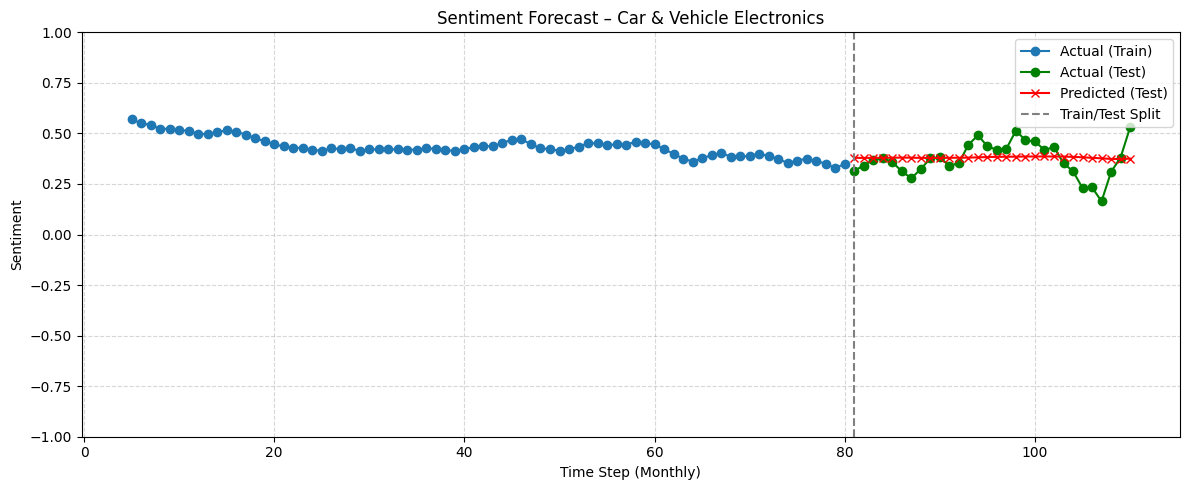

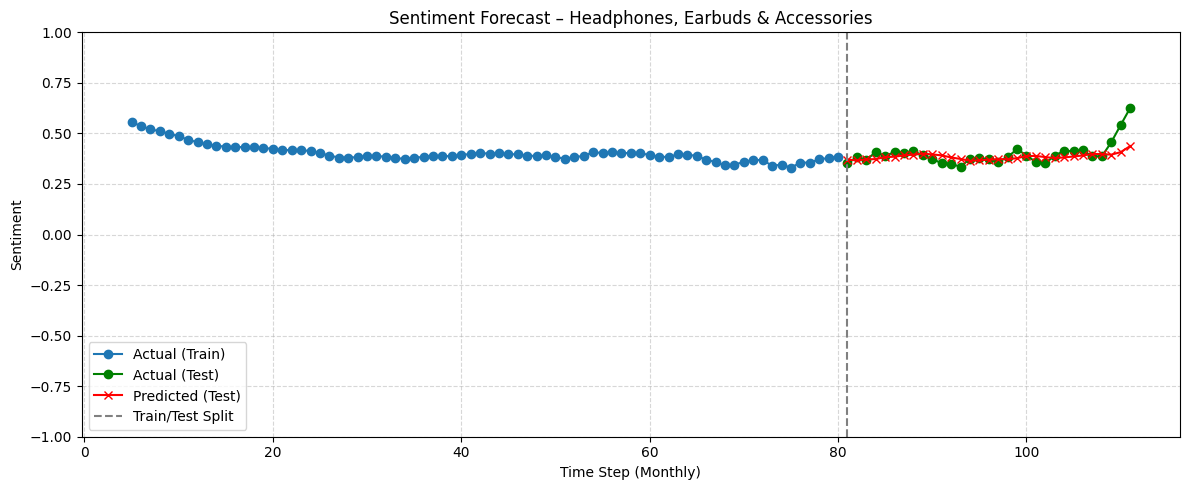

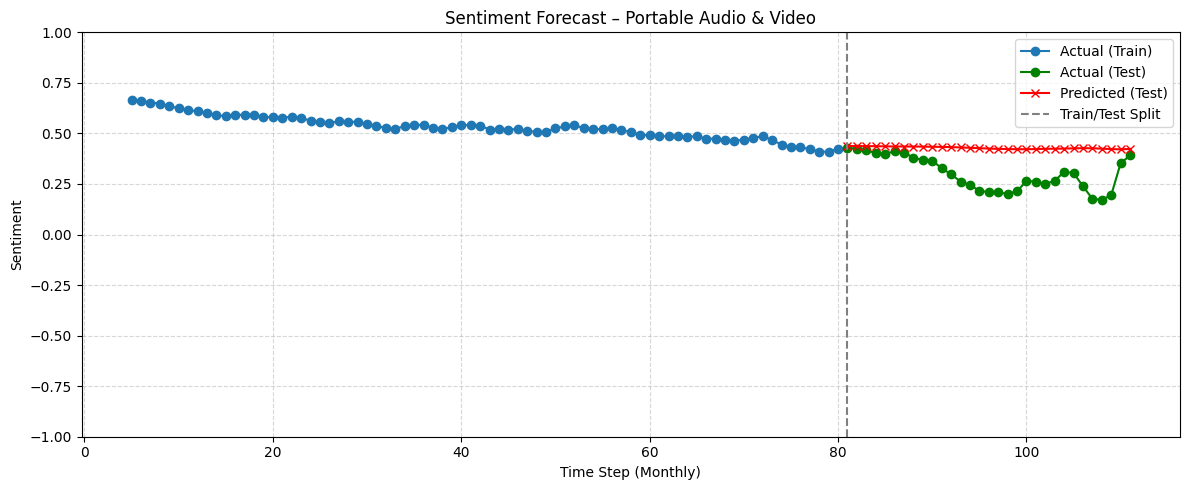

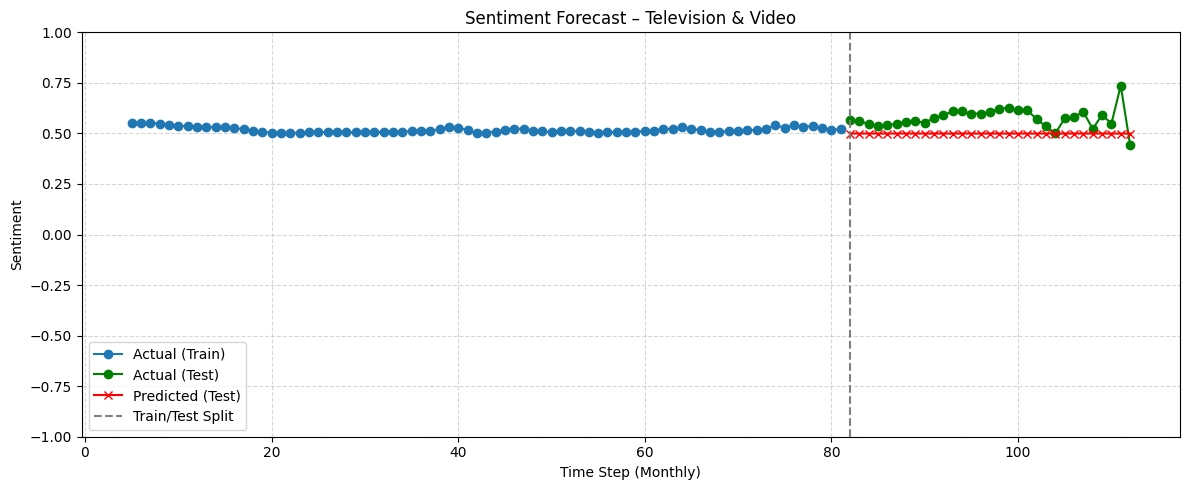

In [ ]:
lstm_results = tune_lstm_hyperparameters(result, param_grid, epochs=50)
plot_realistic_predictions(result,lstm_results)

Deep LSTM Model

In [ ]:
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3, dropout=0.2, output_size=1):
        super(DeepLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.layer_norm(out[:, -1, :])
        return self.fc(out)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

def tune_deep_lstm_hyperparameters(
    result_dict,
    param_grid,
    epochs=100,
    verbose=True
):
    results = []
    combinations = list(itertools.product(
        param_grid["sequence_length"],
        param_grid["hidden_size"],
        param_grid["dropout"],
        param_grid["weight_decay"],
        param_grid["patience"],
        param_grid["num_layers"]
    ))

    for sub_cat, df in result_dict.items():
        y = df["smoothed_sentiment"].dropna().values
        if len(y) < 20:
            continue

        for seq_len, hidden, drop, decay, pat, layers in combinations:
            if drop > 0 and layers == 1:
                continue 

            scaler = MinMaxScaler()
            y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

            split_idx = int(len(y_scaled) * 0.7)
            train_seq, test_seq = y_scaled[:split_idx], y_scaled[split_idx:]
            X_train, y_train = create_sequences(train_seq, seq_len)
            X_test, y_test = create_sequences(test_seq, seq_len)

            if len(X_test) < 5 or len(X_train) < 5:
                continue

            X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
            y_train_tensor = torch.FloatTensor(y_train)
            X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
            y_test_tensor = torch.FloatTensor(y_test)

            model = DeepLSTMModel(hidden_size=hidden, num_layers=layers, dropout=drop)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=decay)

            train_losses, val_losses = [], []
            best_val_loss = float("inf")
            best_model = None
            epochs_no_improve = 0

            for epoch in range(epochs):
                model.train()
                output = model(X_train_tensor).squeeze()
                loss = criterion(output, y_train_tensor)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.eval()
                with torch.no_grad():
                    val_pred = model(X_test_tensor).squeeze()
                    val_loss = criterion(val_pred, y_test_tensor)

                train_losses.append(loss.item())
                val_losses.append(val_loss.item())

                if val_loss.item() < best_val_loss:
                    best_val_loss = val_loss.item()
                    best_model = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= pat:
                        break

            model.load_state_dict(best_model)
            model.eval()
            with torch.no_grad():
                preds = model(X_test_tensor).squeeze().numpy()
                y_true = y_test_tensor.numpy()

            preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
            y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(y_true_inv, preds_inv)
            mse = mean_squared_error(y_true_inv, preds_inv)

            results.append({
                "Subcategory": sub_cat,
                "Sequence Length": seq_len,
                "Hidden Size": hidden,
                "Dropout": drop,
                "Weight Decay": decay,
                "Patience": pat,
                "Num Layers": layers,
                "MAE": mae,
                "MSE": mse,
                "Train Final Loss": train_losses[-1],
                "Val Final Loss": val_losses[-1],
                "Epochs Trained": len(train_losses),
                "Train Losses": train_losses,
                "Val Losses": val_losses
            })

            if verbose:
                print(f"[{sub_cat}] seq={seq_len}, hidden={hidden}, drop={drop}, layers={layers} → MAE={mae:.3f}, MSE={mse:.3f}")

    return pd.DataFrame(results)


In [11]:
param_grid = {
    "sequence_length": [5],
    "hidden_size": [32, 64],
    "dropout": [0.0, 0.2],
    "weight_decay": [0.0, 1e-5],
    "patience": [5, 10],
    "num_layers": [1, 2]
}

deep_results = tune_deep_lstm_hyperparameters(result, param_grid)

[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.080, MSE=0.008
[Television & Video] seq=5, hidden=32, drop=0.0, layers=2 → MAE=0.172, MSE=0.032
[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.083, MSE=0.009
[Television & Video] seq=5, hidden=32, drop=0.0, layers=2 → MAE=0.073, MSE=0.007


[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.132, MSE=0.020
[Television & Video] seq=5, hidden=32, drop=0.0, layers=2 → MAE=0.142, MSE=0.023
[Television & Video] seq=5, hidden=32, drop=0.0, layers=1 → MAE=0.094, MSE=0.011
[Television & Video] seq=5, hidden=32, drop=0.0, layers=2 → MAE=0.062, MSE=0.006
[Television & Video] seq=5, hidden=32, drop=0.2, layers=2 → MAE=0.121, MSE=0.017
[Television & Video] seq=5, hidden=32, drop=0.2, layers=2 → MAE=0.061, MSE=0.005
[Television & Video] seq=5, hidden=32, drop=0.2, layers=2 → MAE=0.093, MSE=0.010
[Television & Video] seq=5, hidden=32, drop=0.2, layers=2 → MAE=0.081, MSE=0.008
[Television & Video] seq=5, hidden=64, drop=0.0, layers=1 → MAE=0.089, MSE=0.010
[Television & Video] seq=5, hidden=64, drop=0.0, layers=2 → MAE=0.187, MSE=0.037
[Television & Video] seq=5, hidden=64, drop=0.0, layers=1 → MAE=0.085, MSE=0.009
[Television & Video] seq=5, hidden=64, drop=0.0, layers=2 → MAE=0.085, MSE=0.009
[Television & Video] seq=5, 

In [ ]:
def plot_realistic_predictions_deep_lstm(result_dict, tuning_results):
    from sklearn.preprocessing import MinMaxScaler
    import matplotlib.pyplot as plt

    class DeepLSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2, output_size=1):
            super(DeepLSTMModel, self).__init__()
            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0.0,
                batch_first=True
            )
            self.layer_norm = nn.LayerNorm(hidden_size)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.layer_norm(out[:, -1, :])
            return self.fc(out)

    best_rows = tuning_results.loc[tuning_results.groupby("Subcategory")["MAE"].idxmin()]

    for _, row in best_rows.iterrows():
        sub_cat = row["Subcategory"]
        if sub_cat not in result_dict:
            continue

        y = result_dict[sub_cat]["smoothed_sentiment"].dropna().values
        if len(y) < 20:
            continue

        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

        seq_len = int(row["Sequence Length"])
        hidden = int(row["Hidden Size"])
        layers = int(row["Num Layers"])
        drop = float(row["Dropout"])
        decay = float(row["Weight Decay"])
        pat = int(row["Patience"])

        split_idx = int(len(y_scaled) * 0.7)
        train_seq, test_seq = y_scaled[:split_idx], y_scaled[split_idx:]
        X_train, y_train = create_sequences(train_seq, seq_len)
        X_test, y_test = create_sequences(test_seq, seq_len)

        if len(X_test) < 5 or len(X_train) < 5:
            continue

        X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
        y_train_tensor = torch.FloatTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
        y_test_tensor = torch.FloatTensor(y_test)

        model = DeepLSTMModel(hidden_size=hidden, num_layers=layers, dropout=drop)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=decay)

        best_val_loss = float("inf")
        epochs_no_improve = 0

        for epoch in range(100):
            model.train()
            output = model(X_train_tensor).squeeze()
            loss = criterion(output, y_train_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_test_tensor).squeeze()
                val_loss = criterion(val_output, y_test_tensor)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= pat:
                    break

        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            preds_test = model(X_test_tensor).squeeze().numpy()

        preds_test_inv = scaler.inverse_transform(preds_test.reshape(-1, 1)).flatten()
        y_test_inv = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()
        y_train_inv = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1)).flatten()

        train_start = seq_len
        test_start = train_start + len(y_train_inv)

        plt.figure(figsize=(12, 5))
        plt.plot(range(train_start, train_start + len(y_train_inv)), y_train_inv, label="Actual (Train)", marker='o')
        plt.plot(range(test_start, test_start + len(y_test_inv)), y_test_inv, label="Actual (Test)", marker='o', color='green')
        plt.plot(range(test_start, test_start + len(preds_test_inv)), preds_test_inv, label="Predicted (Test)", marker='x', color='red')
        plt.axvline(x=test_start, color='gray', linestyle='--', label="Train/Test Split")
        plt.title(f"Deep LSTM Forecast – {sub_cat}")
        plt.xlabel("Time Step (Monthly)")
        plt.ylabel("Sentiment")
        plt.ylim(-1, 1)
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


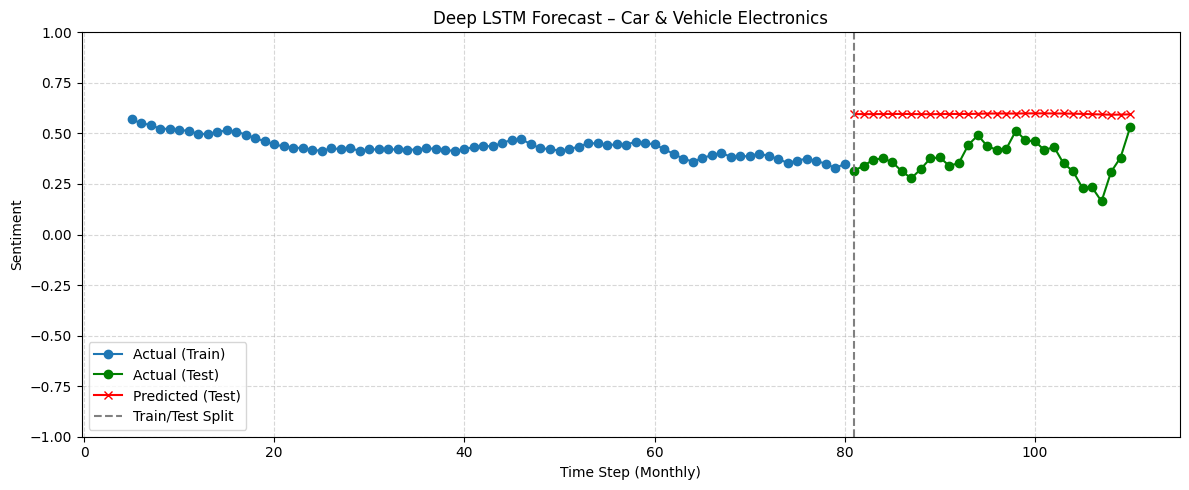

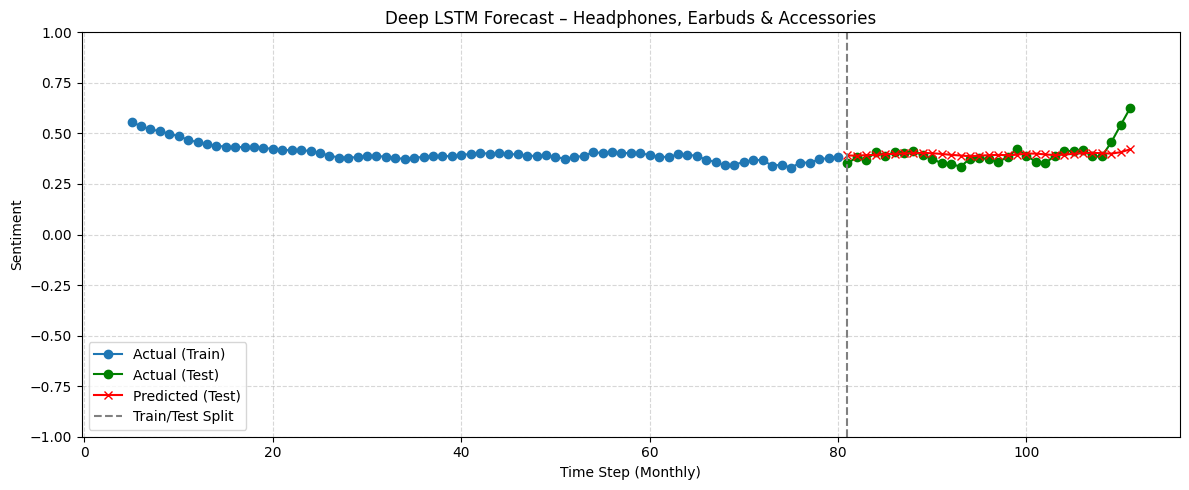

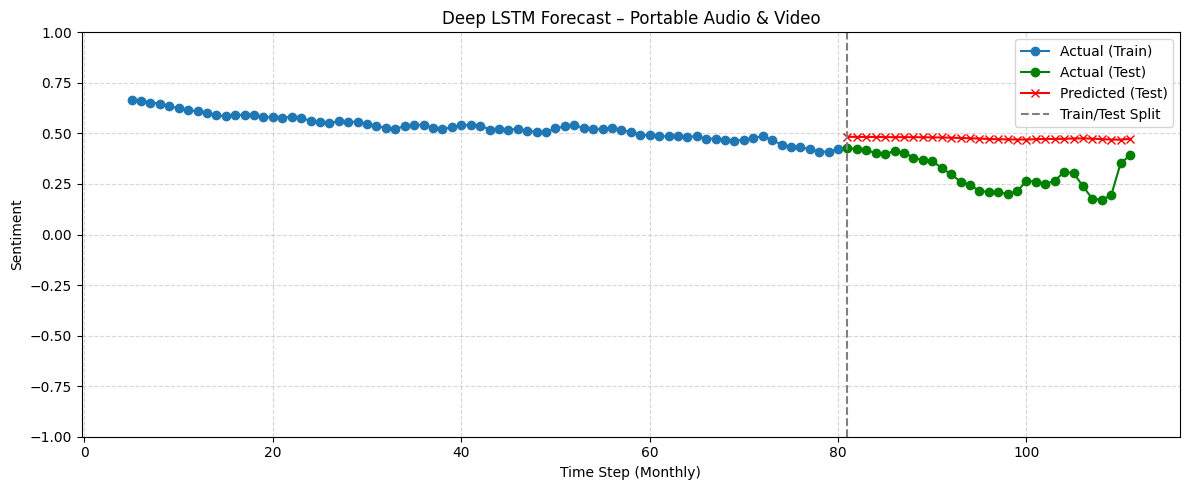

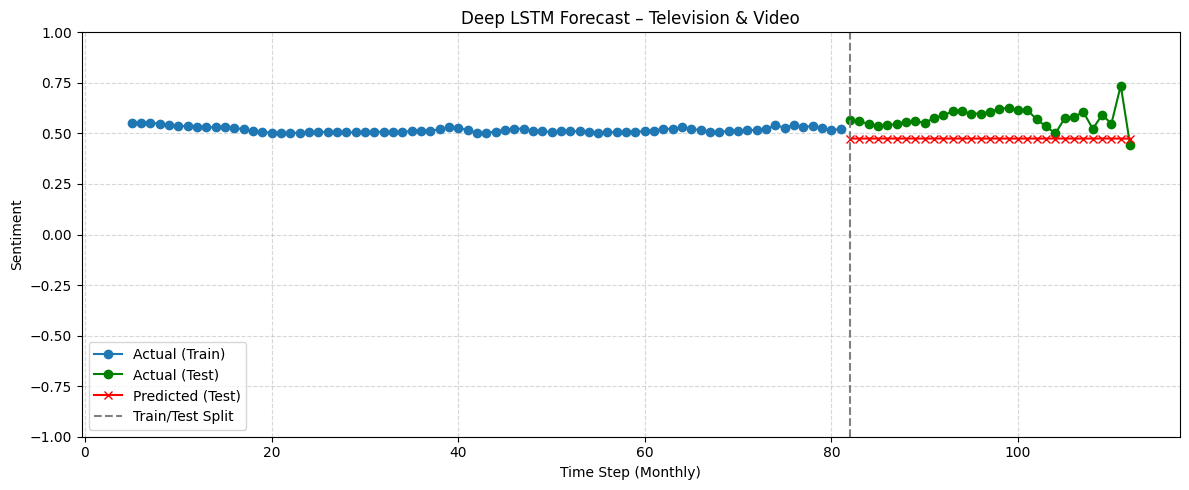

In [13]:
plot_realistic_predictions_deep_lstm(result, deep_results)

Transformer Model

In [ ]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_layer(x[:, -1])

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

def train_transformer_for_each_subcat(result_dict, seq_len=5, epochs=100, patience=10):
    device = torch.device("cpu") 

    results = []
    for sub_cat, df in result_dict.items():
        y = df["smoothed_sentiment"].dropna().values
        if len(y) < seq_len + 10:
            continue

        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

        split_idx = int(len(y_scaled) * 0.7)
        train_y, test_y = y_scaled[:split_idx], y_scaled[split_idx:]

        X_train, y_train = create_sequences(train_y, seq_len)
        X_test, y_test = create_sequences(test_y, seq_len)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

        model = TransformerRegressor().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        best_model = None
        best_val_loss = float("inf")
        no_improve = 0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            pred = model(X_train_tensor).squeeze()
            loss = criterion(pred, y_train_tensor)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_pred = model(X_test_tensor).squeeze()
                val_loss = criterion(val_pred, y_test_tensor)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model = model.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        model.load_state_dict(best_model)
        model.eval()
        with torch.no_grad():
            preds = model(X_test_tensor).squeeze().cpu().numpy()

        y_pred_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        y_true_inv = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)).flatten()

        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        mse = mean_squared_error(y_true_inv, y_pred_inv)

        print(f"[{sub_cat}] MAE: {mae:.4f}, MSE: {mse:.4f}")

        results.append({
            "Subcategory": sub_cat,
            "MAE": mae,
            "MSE": mse
        })

        plt.figure(figsize=(10, 4))
        plt.plot(range(len(y_true_inv)), y_true_inv, label="Actual", marker='o')
        plt.plot(range(len(y_pred_inv)), y_pred_inv, label="Predicted", marker='x')
        plt.title(f"Transformer Forecast – {sub_cat}")
        plt.xlabel("Time Step")
        plt.ylabel("Sentiment")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)


[Television & Video] MAE: 0.0342, MSE: 0.0024


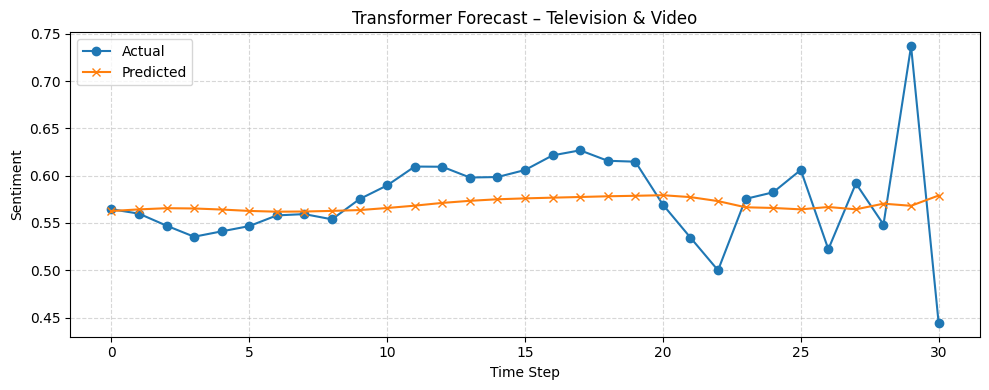

[Portable Audio & Video] MAE: 0.0375, MSE: 0.0023


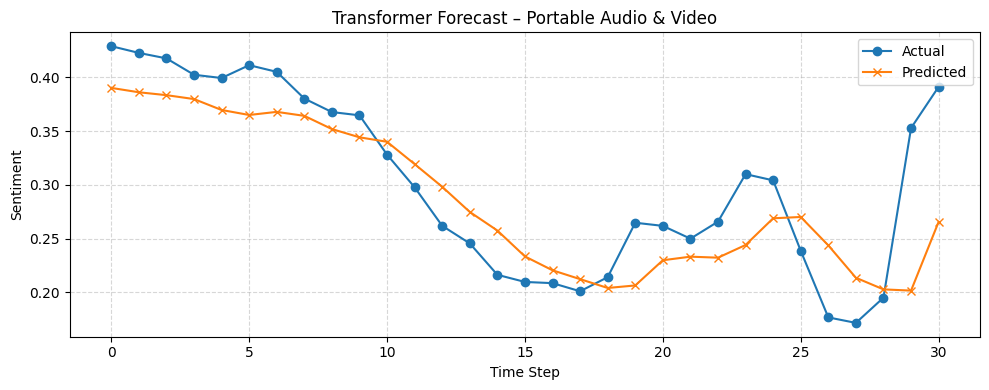

[Headphones, Earbuds & Accessories] MAE: 0.0281, MSE: 0.0019


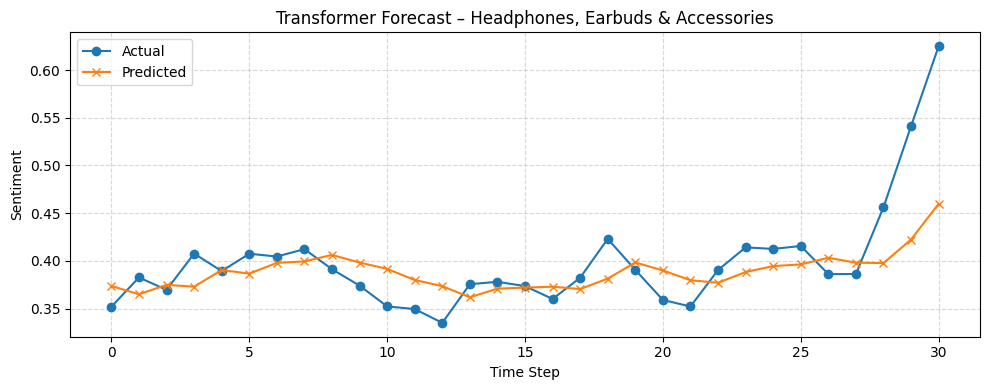

[Car & Vehicle Electronics] MAE: 0.0492, MSE: 0.0046


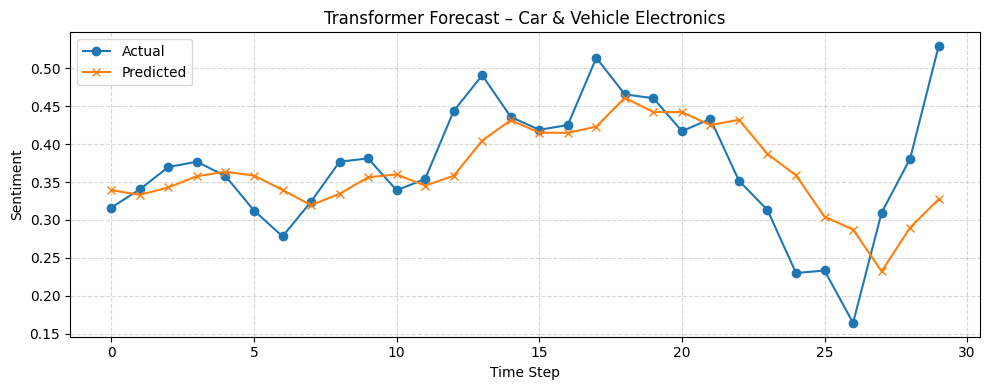

In [15]:
transformer_results = train_transformer_for_each_subcat(result, seq_len=5, epochs=100, patience=10)

Comparing Final Loss

In [ ]:
def print_best_losses(lstm_df, deep_lstm_df, transformer_df):
    print("\n===== Final Losses for Best Models per Subcategory =====\n")
    subcats = set(lstm_df['Subcategory']).union(deep_lstm_df['Subcategory']).union(transformer_df['Subcategory'])

    rows = []
    for sub in sorted(subcats):
        row = {"Subcategory": sub}

        if sub in lstm_df["Subcategory"].values:
            val_loss = lstm_df[lstm_df["Subcategory"] == sub]["Val Final Loss"].min()
            row["LSTM Test Loss"] = round(val_loss, 4)
        else:
            row["LSTM Test Loss"] = "N/A"

        if sub in deep_lstm_df["Subcategory"].values:
            val_loss = deep_lstm_df[deep_lstm_df["Subcategory"] == sub]["Val Final Loss"].min()
            row["Deep LSTM Test Loss"] = round(val_loss, 4)
        else:
            row["Deep LSTM Test Loss"] = "N/A"

        if sub in transformer_df["Subcategory"].values:
            test_mse = transformer_df[transformer_df["Subcategory"] == sub]["MSE"].min()
            row["Transformer Test MSE"] = round(test_mse, 4)
        else:
            row["Transformer Test MSE"] = "N/A"

        rows.append(row)

    loss_table = pd.DataFrame(rows)
    print(loss_table.to_string(index=False))
    return loss_table

print_best_losses(lstm_results, deep_results, transformer_results)



===== Final Losses for Best Models per Subcategory =====

                      Subcategory  LSTM Test Loss  Deep LSTM Test Loss  Transformer Test MSE
        Car & Vehicle Electronics          0.0364               0.0369                0.0046
Headphones, Earbuds & Accessories          0.0223               0.0198                0.0019
           Portable Audio & Video          0.0677               0.1796                0.0023
               Television & Video          0.0591               0.0393                0.0024


,Subcategory,LSTM Test Loss,Deep LSTM Test Loss,Transformer Test MSE
0,Car & Vehicle Electronics,0.0364,0.0369,0.0046
1,"Headphones, Earbuds & Accessories",0.0223,0.0198,0.0019
2,Portable Audio & Video,0.0677,0.1796,0.0023
3,Television & Video,0.0591,0.0393,0.0024
